## Template Placement Metric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lal

from pycbc.conversions import tau0_from_mass1_mass2, tau3_from_mass1_mass2
from pycbc.conversions import mass1_from_tau0_tau3, mass2_from_tau0_tau3
from pycbc.conversions import mass2_from_mchirp_mass1, mchirp_from_tau0
from pycbc.conversions import mchirp_from_mass1_mass2
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q

from tqdm import tqdm

/tmp/ipykernel_1430631/2239071156.py:4: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
from scipy.stats import beta
import multiprocessing

## Parameters

In [3]:
m_min = 7.0 # Msun
m_max = 50.0 # Msun
fL = 20.0 # Hz

method_1 = False
method_2 = True

In [4]:
num_samples = 10_000_000
foo_1 = np.random.uniform(m_min, m_max, num_samples)
foo_2 = np.random.uniform(m_min, m_max, num_samples)
masses = np.column_stack((foo_1, foo_2))
masses = np.sort(masses, axis=1)

In [5]:
mass1, mass2 = (masses[:,1], masses[:,0])
print(mass1, mass2)

[38.87313438 43.73948454 19.16133336 ... 49.24454725 43.64050221
 46.63565829] [21.82825742 42.0372885  17.14846875 ...  9.51247038 29.20058624
 27.57581667]


In [6]:
# Get tau0 and tau3 from uniform m1, m2 (m1>m2)
tau0 = tau0_from_mass1_mass2(mass1, mass2, f_lower=fL)
tau3 = tau3_from_mass1_mass2(mass1, mass2, f_lower=fL)

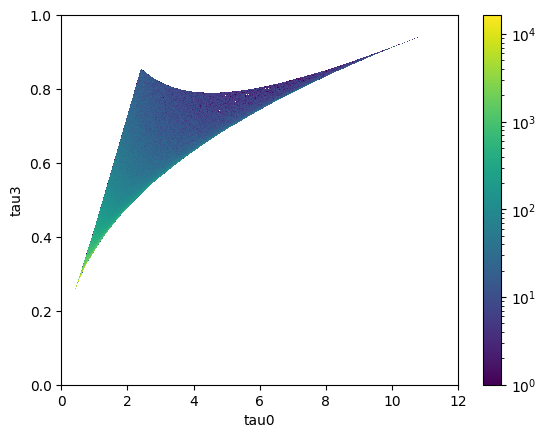

In [7]:
plt.hist2d(tau0, tau3, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('tau0')
plt.ylabel('tau3')
plt.xlim(0.0, 12.0)
plt.ylim(0.0, 1.0)
plt.colorbar()
plt.show()

[38.87313438 43.73948454] [21.82825742 42.0372885 ]


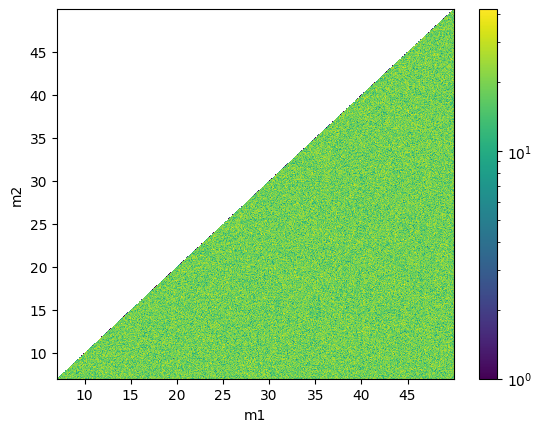

In [8]:
plt.hist2d(mass1, mass2, bins=1024, norm=mpl.colors.LogNorm())
print(mass1[:2], mass2[:2])
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar()
plt.show()

## Sampling uniform on (tau0, tau3) - WRONG

In [9]:
# Placing templates uniform in the (tau0, tau3) space
# The boundaries of tau3 are at m1=m2=m_max and m1=m2=m_min
tau3_boundary_1 = tau3_from_mass1_mass2(m_max, m_max, f_lower=fL)
tau3_boundary_2 = tau3_from_mass1_mass2(m_min, m_min, f_lower=fL)

# The boundaries of tau0 are at also at the same locations
tau0_boundary_1 = tau0_from_mass1_mass2(m_max, m_max, f_lower=fL)
tau0_boundary_2 = tau0_from_mass1_mass2(m_min, m_min, f_lower=fL)

In [10]:
# This makes sense
print(tau0_boundary_1, tau0_boundary_2)
print(tau3_boundary_1, tau3_boundary_2)

0.40759405349866723 10.798110809905172
0.2536220914789963 0.9406651529313066


In [11]:
# Is it possible to sample in (tau0, tau3) via constant lines of tau0
# We can place boundaries in (m1, m2) by placing relevant boundaries on tau3
const_tau0 = 4.0 # Say

# The lower boundary will always intersect the m1=m2 line
# m1=m2 corresponds to eta=0.25
A3 = np.pi / (8.0 * (np.pi*fL)**(5./3.))
A0 = 5.0 / (256.0 * (np.pi*fL)**(8./3.))
lower_boundary_tau3 = 4.0*A3 * (const_tau0/(4.0*A0))**(2./5.)

In [12]:
# The upper boundary
# Real root to the cubic equation
u1_func = lambda p,q: (-q/2.) + ((0.25*q**2.)+((1./27.)*p**3.))**0.5
u2_func = lambda p,q: (-q/2.) - ((0.25*q**2.)+((1./27.)*p**3.))**0.5

if method_1 == True:
    p_func = lambda t0, me: (-A0/(t0*me))
    q_func = lambda me: -me

    # The boundary here is chosen based on tau0 where m1=m_max and m2=m_min
    inflection_tau0 = tau0_from_mass1_mass2(m_max, m_min, f_lower=fL)
    # There are three separate types of solutions
    flag = 0
    if const_tau0 > inflection_tau0:
        m_ext = m_max # m2=m_min and m1=[m_min, m_max]
        flag = 1
    elif const_tau0 < inflection_tau0:
        m_ext = m_max # m1=m_max and m2=[m_min, m_max]
        flag = 1
    elif const_tau0 == inflection_tau0:
        # edge case: tau3 upper boundary where m1=m_max and m2=m_min
        upper_boundary_tau3 = tau3_from_mass1_mass2(m_max, m_min, f_lower=fL)

    if flag == 1:
        # Real root of cubic equation is M^(1./3.) where M is total mass
        p = p_func(const_tau0, m_ext)
        q = q_func(m_ext)
        real_root = u1_func(p,q)**(1./3.) + u2_func(p,q)**(1./3.)
        M = real_root**3.
        # Compute tau3 from M. This will be the upper boundary given tau0.
        upper_boundary_tau3 = (A3/A0) * const_tau0 * M*lal.MTSUN_SI

elif method_2 == True:
    # The boundary here is chosen based on tau0 where m1=m_max and m2=m_min
    inflection_tau0 = tau0_from_mass1_mass2(m_max, m_min, f_lower=fL)
    if const_tau0 > inflection_tau0:
        # m2=m_min and m1=[m_min, m_max]
        mchirp = mchirp_from_tau0(const_tau0, f_lower=fL)
        # m1,m2 can be interchanged assuming the func can return m2>m1
        estimated_m1 = mass2_from_mchirp_mass1(mchirp, m_min)
        upper_boundary_tau3 = tau3_from_mass1_mass2(estimated_m1, m_min, f_lower=fL)
    elif const_tau0 < inflection_tau0:
        # m1=m_max and m2=[m_min, m_max]
        mchirp = mchirp_from_tau0(const_tau0, f_lower=fL)
        estimated_m2 = mass2_from_mchirp_mass1(mchirp, m_max)
        upper_boundary_tau3 = tau3_from_mass1_mass2(m_max, estimated_m2, f_lower=fL)
    elif const_tau0 == inflection_tau0:
        # edge case: tau3 upper boundary where m1=m_max and m2=m_min
        upper_boundary_tau3 = tau3_from_mass1_mass2(m_max, m_min, f_lower=fL)

In [13]:
# Lower boundary looks fine, upper boundary is wrong
# Not sure how to fix this
print(lower_boundary_tau3, upper_boundary_tau3)

0.6322952807726924 0.7928386337349054


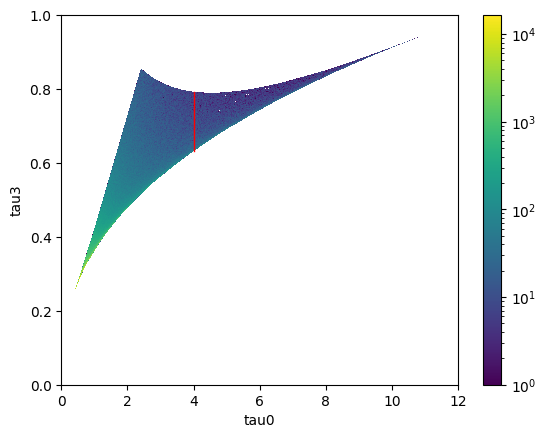

In [14]:
# Plot the bounded tau3 alongside the 2D histogram of (tau0, tau3) for verification
plt.hist2d(tau0, tau3, bins=1024, norm=mpl.colors.LogNorm())
plt.plot([const_tau0, const_tau0], [lower_boundary_tau3, upper_boundary_tau3], linewidth=1, c='red')
plt.xlabel('tau0')
plt.ylabel('tau3')
plt.xlim(0.0, 12.0)
plt.ylim(0.0, 1.0)
plt.colorbar()
plt.show()

In [15]:
# Draw uniformly on tau0
utau0 = np.random.uniform(tau0_boundary_1, tau0_boundary_2, num_samples)

In [16]:
def tau3_lower_boundary_from_tau0(_tau0):
    # The lower boundary will always intersect the m1=m2 line
    # m1=m2 corresponds to eta=0.25
    A3 = np.pi / (8.0 * (np.pi*fL)**(5./3.))
    A0 = 5.0 / (256.0 * (np.pi*fL)**(8./3.))
    lower_boundary_tau3 = 4.0*A3 * (_tau0/(4.0*A0))**(2./5.)
    return lower_boundary_tau3

In [17]:
def tau3_upper_boundary_from_tau0(_tau0):
    # The boundary here is chosen based on tau0 where m1=m_max and m2=m_min
    inflection_tau0 = tau0_from_mass1_mass2(m_max, m_min, f_lower=fL)
    if _tau0 > inflection_tau0:
        # m2=m_min and m1=[m_min, m_max]
        mchirp = mchirp_from_tau0(_tau0, f_lower=fL)
        # m1,m2 can be interchanged assuming the func can return m2>m1
        estimated_m1 = mass2_from_mchirp_mass1(mchirp, m_min)
        upper_boundary_tau3 = tau3_from_mass1_mass2(estimated_m1, m_min, f_lower=fL)
    elif _tau0 < inflection_tau0:
        # m1=m_max and m2=[m_min, m_max]
        mchirp = mchirp_from_tau0(_tau0, f_lower=fL)
        estimated_m2 = mass2_from_mchirp_mass1(mchirp, m_max)
        upper_boundary_tau3 = tau3_from_mass1_mass2(m_max, estimated_m2, f_lower=fL)
    elif _tau0 == inflection_tau0:
        # edge case: tau3 upper boundary where m1=m_max and m2=m_min
        upper_boundary_tau3 = tau3_from_mass1_mass2(m_max, m_min, f_lower=fL)
    return upper_boundary_tau3

In [18]:
utau3 = []
for _utau0 in tqdm(utau0):
    lb_tau3 = tau3_lower_boundary_from_tau0(_utau0)
    ub_tau3 = tau3_upper_boundary_from_tau0(_utau0)
    utau3.append(np.random.uniform(lb_tau3, ub_tau3))

  1%|▏         | 131860/10000000 [00:19<24:01, 6847.41it/s]

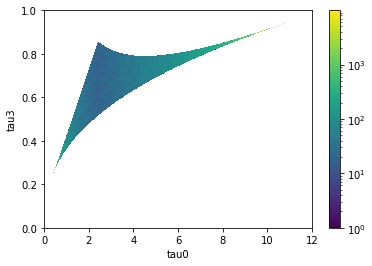

In [ ]:
# Plot the bounded tau3 alongside the 2D histogram of (tau0, tau3) for verification
# This should be uniform on (tau0, tau3) and bounded by m1, m2 constraints
utau3 = np.array(utau3)
plt.hist2d(utau0, utau3, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('tau0')
plt.ylabel('tau3')
plt.xlim(0.0, 12.0)
plt.ylim(0.0, 1.0)
plt.colorbar()
plt.show()

In [ ]:
# Converting (tau0, tau3) to (m1, m2)
mass1_metric = mass1_from_tau0_tau3(utau0, utau3, f_lower=fL)
mass2_metric = mass2_from_tau0_tau3(utau0, utau3, f_lower=fL)

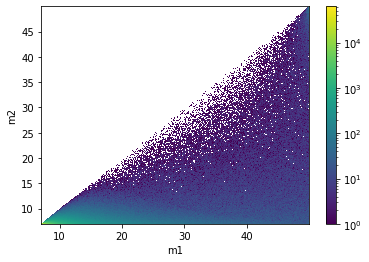

In [ ]:
plt.hist2d(mass1_metric, mass2_metric, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar()
plt.show()

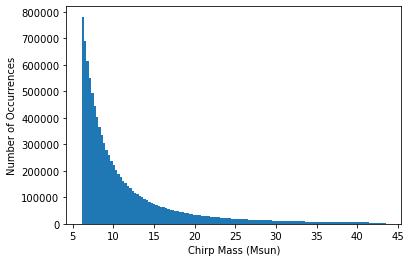

In [ ]:
# Plot the other params
mchirp_metric = mchirp_from_mass1_mass2(mass1_metric, mass2_metric)
q_metric = mass1_metric/mass2_metric

plt.hist(mchirp_metric, bins=128)
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Number of Occurrences')
plt.show()

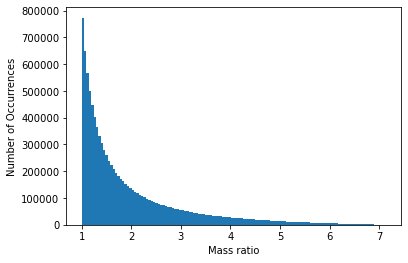

In [ ]:
# This isn't too different from a uniform distribution on (m1, m2)
plt.hist(q_metric, bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

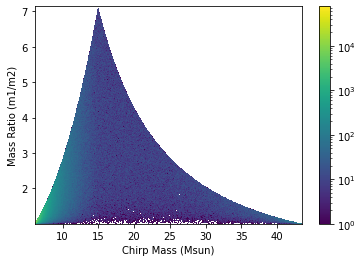

In [ ]:
plt.hist2d(mchirp_metric, q_metric, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Mass Ratio (m1/m2)')
plt.colorbar()
plt.show()

## Rejection Sampling and U(tau0, tau3)

In [ ]:
# We have the means to tell whether a given (tau0, tau3) is within the bounds provided
# All we have to do is create samples uniform on (tau0, tau3)
tau0 = np.random.uniform(tau0_boundary_1, tau0_boundary_2, num_samples)
tau3 = np.random.uniform(tau3_boundary_1, tau3_boundary_2, num_samples)

In [ ]:
# For each point check whether it is within boundary
all_coords = zip(tau0, tau3)
accepted_coords = []
counter = 0

def get_good_samples(coords):
    t0, t3 = coords
    lb_tau3 = tau3_lower_boundary_from_tau0(t0)
    ub_tau3 = tau3_upper_boundary_from_tau0(t0)
    if lb_tau3 <= t3 <= ub_tau3:
        return coords
    else:
        return (-1, -1)

In [ ]:
pool = multiprocessing.Pool(multiprocessing.cpu_count()-2)
atau0, atau3 = zip(*pool.map(get_good_samples, all_coords))

In [ ]:
# Filter the output to get valid points
atau0 = np.array(atau0)
atau3 = np.array(atau3)

atau0 = atau0[atau0 > 0.0]
atau3 = atau3[atau3 > 0.0]

# That is about 13.4% efficiency
print(len(atau0), len(atau3))

1337822 1337822


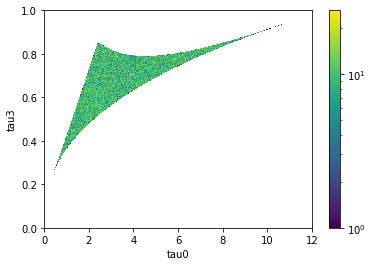

In [ ]:
plt.hist2d(atau0, atau3, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('tau0')
plt.ylabel('tau3')
plt.xlim(0.0, 12.0)
plt.ylim(0.0, 1.0)
plt.colorbar()
plt.show()

In [ ]:
# Plot the other params
# Converting (tau0, tau3) to (m1, m2)
amass1 = mass1_from_tau0_tau3(atau0, atau3, f_lower=fL)
amass2 = mass2_from_tau0_tau3(atau0, atau3, f_lower=fL)

amchirp = mchirp_from_mass1_mass2(amass1, amass2)
aq = amass1/amass2

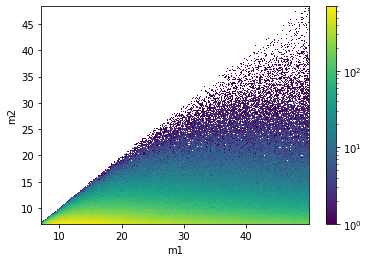

In [ ]:
plt.hist2d(amass1, amass2, bins=256, norm=mpl.colors.LogNorm())
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar()
plt.show()

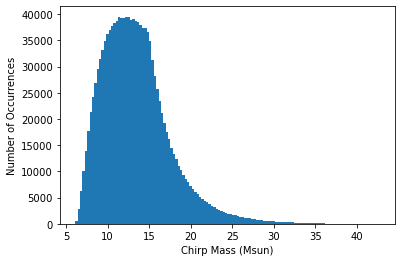

In [ ]:
plt.hist(amchirp, bins=128)
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Number of Occurrences')
plt.show()

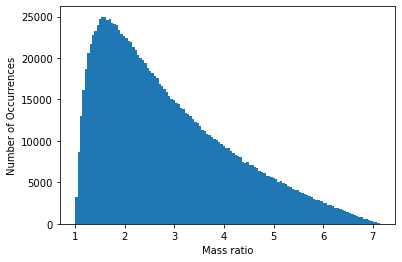

In [ ]:
plt.hist(aq, bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

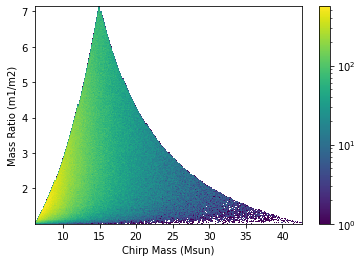

In [ ]:
plt.hist2d(amchirp, aq, bins=256, norm=mpl.colors.LogNorm())
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Mass Ratio (m1/m2)')
plt.colorbar()
plt.show()

## Sampling uniform on (mchirp, q) - WRONG

In [ ]:
# Can we make it uniform on (mchirp, q)
# No cubic roots involved!
# Get lines of const mchirp and find the boundaries on q
# The lower boundary is already fixed at q=1

In [ ]:
def q_upper_boundary_from_mchirp(_mchirp):
    # Maximum value of q (m1/m2) with m1>m2
    inflection_mchirp = mchirp_from_mass1_mass2(m_max, m_min)
    if _mchirp > inflection_mchirp:
        # perpendicular of the m1, m2 right triangle
        # m1=m_max and m2=[m_min, m_max]
        estimated_m2 = mass2_from_mchirp_mass1(_mchirp, m_max)
        upper_boundary_q = m_max/estimated_m2
    elif _mchirp < inflection_mchirp:
        # base of the m1, m2 right triangle
        # m2=m_min and m1=[m_min, m_max]
        # Assuming that the following function does not constrain m1>m2
        estimated_m1 = mass2_from_mchirp_mass1(_mchirp, m_min)
        upper_boundary_q = estimated_m1/m_min
    elif _mchirp == inflection_mchirp:
        # edge case: q upper boundary where m1=m_max and m2=m_min
        upper_boundary_q = m_max/m_min
    return upper_boundary_q

In [ ]:
# Sample uniform on (mchirp, q)
mchirp_low = mchirp_from_mass1_mass2(m_min, m_min)
mchirp_high = mchirp_from_mass1_mass2(m_max, m_max)
umchirp = np.random.uniform(mchirp_low, mchirp_high, num_samples)

In [ ]:
uq = []
for _umchirp in tqdm(umchirp):
    lb_q = 1
    ub_q = q_upper_boundary_from_mchirp(_umchirp)
    uq.append(np.random.uniform(lb_q, ub_q))

100%|██████████| 10000000/10000000 [20:49<00:00, 8003.05it/s]


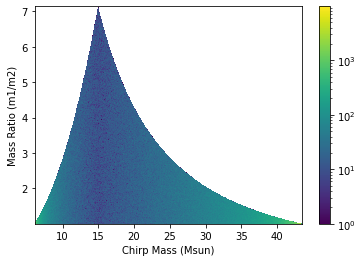

In [ ]:
plt.hist2d(umchirp, uq, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Mass Ratio (m1/m2)')
plt.colorbar()
plt.show()

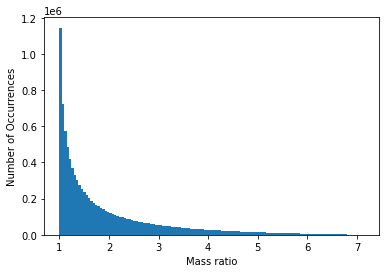

In [ ]:
# This is even more skewed :O
plt.hist(uq, bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

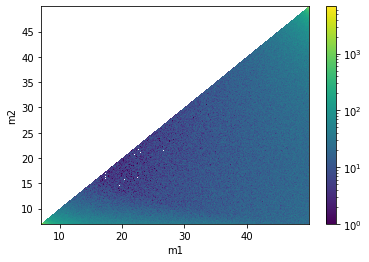

In [ ]:
umchirp = np.array(umchirp)
uq = np.array(uq)
mass1_umcq = mass1_from_mchirp_q(umchirp, uq)
mass2_umcq = mass2_from_mchirp_q(umchirp, uq)

plt.hist2d(mass1_umcq, mass2_umcq, bins=1024, norm=mpl.colors.LogNorm())
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar()
plt.show()

## Sampling power-law on q

In [ ]:
import matplotlib.pyplot as plt
from pycbc import distributions
from pycbc import conversions
import numpy as np

# Create chirp mass and mass ratio distribution object that is uniform
# in mass1 and mass2
minmc = mchirp_low
maxmc = mchirp_high
mc_distribution = distributions.MchirpfromUniformMass1Mass2(mc=(minmc,maxmc))
# generate q in a symmetric range [min, 1/min] to make mass1 and mass2
# symmetric
minq = 1/7
maxq = 1/minq
q_distribution = distributions.QfromUniformMass1Mass2(q=(minq,maxq))

# Take 100000 random variable samples from this chirp mass and mass ratio
# distribution.
n_size = 100000
mc_samples = mc_distribution.rvs(size=n_size)
q_samples = q_distribution.rvs(size=n_size)

# Convert chirp mass and mass ratio to mass1 and mass2
m1 = conversions.mass1_from_mchirp_q(mc_samples['mc'],q_samples['q'])
m2 = conversions.mass2_from_mchirp_q(mc_samples['mc'],q_samples['q'])

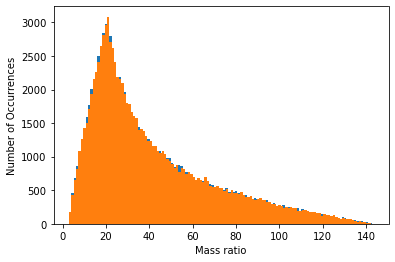

In [ ]:
plt.hist(m1, bins=128)
plt.hist(m2, bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

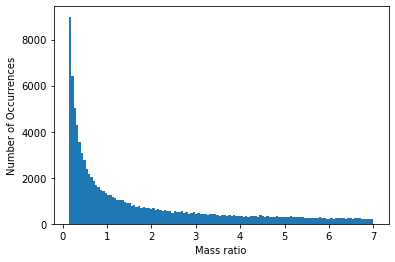

In [ ]:
plt.hist(m1/m2, bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

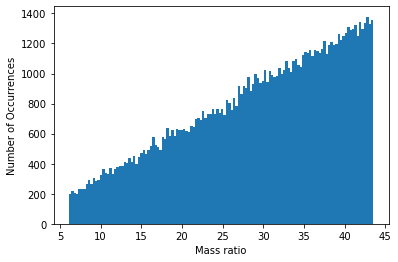

In [ ]:
plt.hist(mc_samples['mc'], bins=128)
plt.xlabel('Mass ratio')
plt.ylabel('Number of Occurrences')
plt.show()

## Custom Chirp mass and q

In [ ]:
# Sample on const tau and const q lines together

def get_mchirp_priors(ml, mu):
    # Range for mchirp
    min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
    max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
    return (min_mchirp, max_mchirp)

def get_tau_priors(ml, mu, lf):
    # Range for mchirp
    min_mchirp, max_mchirp = get_mchirp_priors(ml, mu)
    # Tau priors
    G = 6.67e-11 # Nm^2/Kg^2
    c = 3.0e8 # ms^-1
    tau = lambda mc: 5. * (8.*np.pi*lf)**(-8./3.) * (mc*1.989e30*G/c**3.)**(-5./3.)
    tau_lower = tau(max_mchirp)
    tau_upper = tau(min_mchirp)
    return (tau_lower, tau_upper)

class BoundedPriors:

    def __init__(self, mu, ml, lf):
        # Common
        self.lf = lf # Hz (signal low freq cutoff)
        self.mu = mu
        self.ml = ml
        # Constants
        G = 6.67e-11 # Nm^2/Kg^2
        c = 3.0e8 # ms^-1
        self.const = (5. * (8.*np.pi*lf)**(-8./3.)) * (1.989e30*G/c**3.)**(-5./3.)

    def _intersection_with_m1_eq_m2(self, tau):
        # Where does the curve intersect with m1=m2?
        C_1dash = self.const * 2**(1./3.)
        intersc_diagonal = (tau/C_1dash)**(-3./5.)
        return intersc_diagonal
    
    def _intersection_with_m2_when_m1_is_mu(self, tau):
        # Where does the curve intersect with x or y axis?
        # Where does it intersect m2 when m1=50.0 Msun?
        C_2dash = self.const/self.mu
        C_3dash = (tau/C_2dash)**3.
        # We get one non-complex root for the value of m2
        m2_when_m1_is_mu = np.array([np.roots([c3d, 0.0, -1, -self.mu]) for c3d in C_3dash])
        m2_when_m1_is_mu = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m2_when_m1_is_mu])
        return m2_when_m1_is_mu

    def _intersection_with_m1_when_m2_is_ml(self, tau):
        # Where does it intersect m1 when m2=7.0 Msun?
        C_4dash = self.const/self.ml
        C_5dash = (tau/C_4dash)**3.
        # We get one non-complex root for the value of m2
        m1_when_m2_is_ml = np.array([np.roots([c5d, 0.0, -1, -self.ml]) for c5d in C_5dash])
        m1_when_m2_is_ml = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m1_when_m2_is_ml])
        return m1_when_m2_is_ml
    
    def _get_m1_upper_bounds(self, m2_when_m1_is_mu, m1_when_m2_is_ml):
        upper_bounds = m2_when_m1_is_mu
        # Checkl if bounds are correct
        idxs = m2_when_m1_is_mu < self.ml
        alt_idxs = m2_when_m1_is_mu >= self.ml
        upper_bounds[idxs] = m1_when_m2_is_ml[idxs]
        upper_bounds[alt_idxs] = np.full(sum(alt_idxs), self.mu)
        return upper_bounds
    
    def _get_m2_from_m1_tau(self, mass1, tau):
        C_6dash = (tau/(self.const/mass1))**3.
        mass2_roots = np.array([np.roots([c6d, 0.0, -1, -_m1]) for c6d, _m1 in zip(C_6dash, mass1)])
        mass2 = np.array([np.real(foo[np.isreal(foo)])[0] for foo in mass2_roots])
        return mass2

    def _custom_tau_q_(self, tau):
        ## Step 2: Find the intersection of const Tau curve on P(m1, m2) where m1, m2 are uniform and m1>m2
        m2_when_m1_is_mu = self._intersection_with_m2_when_m1_is_mu(tau)
        m1_when_m2_is_ml = self._intersection_with_m1_when_m2_is_ml(tau)
        ## Step 3: We can get an upper bound on m1 to get maximum allowed q.
        upper_bounds = self._get_m1_upper_bounds(m2_when_m1_is_mu, m1_when_m2_is_ml)
        # From the upper bounds on m1, get m2
        m2_at_m1_upper_bound = self._get_m2_from_m1_tau(upper_bounds, tau)
        # Maximum value of q allowed for given const tau
        max_q = upper_bounds/m2_at_m1_upper_bound
        ## Step 4: Sample however we want within bounds of q
        # q = np.random.uniform(1.0, max_q)[0]
        # q = (np.random.power(0.5, 1) * (max_q-1.0)) + 1.0
        q = (beta.rvs(2, 1) * (max_q-1.0)) + 1.0
        q = q[0]
        ## Step 5: Obtain m1, m2 from const_mchirp and q
        mchirp = mchirp_from_tau0(tau, self.lf)[0]
        mass1 = mass1_from_mchirp_q(mchirp, q)
        mass2 = mass2_from_mchirp_q(mchirp, q)
        return (mass1, mass2, q, mchirp)

    def get_bounded_gwparams_from_uniform_tau_uniform_q(self):
        ## Step 1a: Get uniform Tau values within bounds provided by m1 and m2
        tau_lower, tau_upper = get_tau_priors(ml=self.ml, mu=self.mu, lf=self.lf)
        tau = np.random.uniform(tau_lower, tau_upper, 1)
        # Common steps
        mass1, mass2, q, mchirp = self._custom_tau_q_(tau)
        return (mass1, mass2, q, mchirp, tau[0])

In [ ]:
bp = BoundedPriors(50.0, 7.0, 20.0)

In [ ]:
m1 = []
m2 = []
q = []
mchirp = []
tau = []

for _ in tqdm(range(1_000_000)):
    _m1, _m2, _q, _mchirp, _tau = bp.get_bounded_gwparams_from_uniform_tau_uniform_q()
    m1.append(_m1)
    m2.append(_m2)
    q.append(_q)
    mchirp.append(_mchirp)
    tau.append(_tau)

100%|██████████| 1000000/1000000 [05:38<00:00, 2951.73it/s]


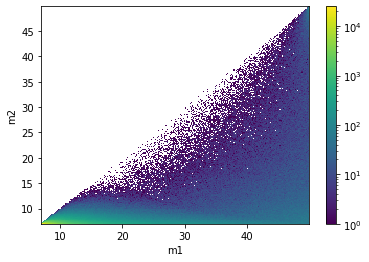

In [ ]:
plt.hist2d(m1, m2, bins=256, norm=mpl.colors.LogNorm())
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar()
plt.show()

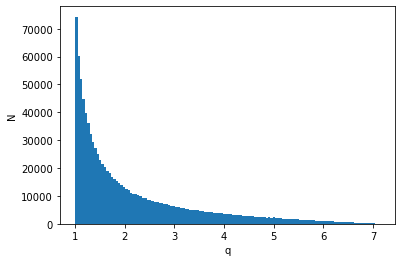

In [ ]:
plt.hist(q, bins=128)
plt.xlabel('q')
plt.ylabel('N')
plt.show()

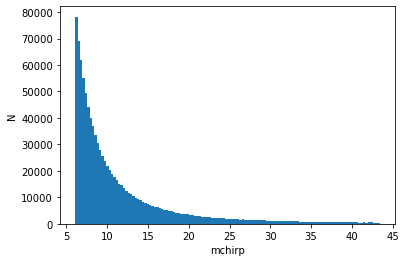

In [ ]:
plt.hist(mchirp, bins=128)
plt.xlabel('mchirp')
plt.ylabel('N')
plt.show()